In [1]:
#IMPORTING ALL THE REQUIRED LIBRARIES
import numpy as np 
import pandas as pd 
import contractions
import nltk
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob, Word, Blobber
from nltk.corpus import wordnet 
import math
import random
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#READING THE DATASET
items="Datasets/IR_Project/amazon-cell-phones-reviews/items.csv"
reviews="Datasets/IR_Project/amazon-cell-phones-reviews/reviews.csv"
items_df=pd.read_csv(items)
reviews_df=pd.read_csv(reviews)

In [3]:
#PREVIEWING DATASET AND VARIOUS ATTRIBUTES
items_df['asin'].count()

720

In [4]:
reviews_df.shape

(67986, 8)

In [5]:
items_df.columns

Index(['asin', 'brand', 'title', 'url', 'image', 'rating', 'reviewUrl',
       'totalReviews', 'price', 'originalPrice'],
      dtype='object')

In [6]:
items_df.head()

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


In [7]:
reviews_df.columns

Index(['asin', 'name', 'rating', 'date', 'verified', 'title', 'body',
       'helpfulVotes'],
      dtype='object')

In [8]:
count=0
for i in range(len(items_df)):
    count+=items_df.iloc[i,7]
print(count)

76089


In [9]:
#FINDING TOTAL NO OF REVIEWS FOR EACH PRODUCT AND SELECTING A GOOD THRESHOLD TO CONSIDER THE REVIEWS IN THE DATA
review_count={}
for i in range(len(items_df)):
    curr_id=items_df.iloc[i,0]
    review_count[curr_id]=0
for i in range(len(reviews_df)):
    curr_id=reviews_df.iloc[i,0]
    review_count[curr_id]+=1

In [10]:
total_reviews=reviews_df.shape[0]
total_items=items_df.shape[0]
avg_reviews=total_reviews//total_items
print(avg_reviews)

94


In [11]:
to_drop=[]
for i in review_count:
    if(review_count[i]<93 or review_count[i]>150):
        to_drop.append(i)

In [12]:
total_remaining=0
final_count={}
for i in review_count:
    if i not in to_drop:
        total_remaining+=review_count[i]
        final_count[i]=review_count[i]
print(total_remaining)
#print(len(final_count))

6245


In [13]:
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
            "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", 
            "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", 
            "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", 
            "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
            "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
            "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", 
            "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
            "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
from nltk.tokenize import RegexpTokenizer
tokenizer= RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
nlp = spacy.load('en', parser=True)
from nltk.tokenize import word_tokenize


In [14]:
#SELECTING THE REQUIREd REVIEWS
index_list=[]
for i in range(len(reviews_df)):
    curr_id=str(reviews_df.iloc[i,0])
    body=reviews_df.iloc[i,6]
    
    #print(curr_id)
    if(curr_id in to_drop):
          index_list.append(i)
            
reviews_df_new=reviews_df.drop(index_list)
print(reviews_df_new.shape)

reviews_df_new=reviews_df_new[['asin','body']]
print(reviews_df_new.shape)

reviews_df_new.dropna(inplace=True)
print(reviews_df_new.shape)


(6245, 8)
(6245, 2)
(6245, 2)


In [15]:
#Funtion to get all aspects from the reviews aspects=nouns
def get_aspects():
    is_noun = lambda pos: pos[:2] == 'NN'
    aspects=set()
    for i in range(len(reviews_df_new)):
        lines=reviews_df_new.iloc[i,1]
        lines=contractions.fix(lines)  #expand the contractions
        lines_one=lines.translate(str.maketrans("","",string.punctuation)) #remove punctuations
        lines_two=lines_one.lower()
        tokens=tokenizer.tokenize(lines_two)
        nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)] 
        aspects=aspects.union(nouns)
        aspect_list=list(aspects)
    print(len(aspect_list))
    return aspects

In [16]:
#Function to generate tf-idf vectors of the reviews
def generate_tf_idf_vector():
    corpus=reviews_df_new['body']
    vectorizer = TfidfVectorizer()
    review_vectors = vectorizer.fit_transform(corpus)
    review_array=review_vectors.toarray()
    return review_array

In [17]:
#FUNCTION TO FIND ALL THE REQUIRED FEATURES


def preprocess():
    local_dict={}
    token_dict={}
    total_dict=set()
    
    for index in range(len(reviews_df_new)):
        print(index)
        text=reviews_df_new.iloc[index,1]
        text=contractions.fix(text)  #expand the contractions
        text_one=text.translate(str.maketrans("","",string.punctuation)) #remove punctuations
        text_two=text_one.lower(); # convert to lower case
        tokens=tokenizer.tokenize(text_two) #tokenization
        tokens_one=[i for i in tokens if not i in stop_words] #stop word removal
        tokens_two=[]
        for word in tokens_one: 
             tokens_two.append(lemmatizer.lemmatize(word)) #lemmatization
        token_dict[index]=tokens_two
        local_dictionary=set(tokens_two)
        total_dict=total_dict.union(local_dictionary)
        local_dict[index]=list(local_dictionary)
    total_dict_list=list(total_dict)
    return local_dict,token_dict,total_dict_list

In [18]:
#Utility function to sort a dict
def sort_dict(input_dict):
    sorted_dict = sorted(input_dict.items(), key=lambda kv: kv[1],reverse=True)
    return sorted_dict

In [19]:
#Finding DF of tokens
def count_df(total_dict_list,local_dict):
    count_token={}
    for i in total_dict_list:
        count_token[i]=0
    for i in range(len(reviews_df_new)):
        for word in local_dict[i]:
            count_token[word]+=1
    return count_token

In [20]:
#Function to completely pre-process the data
def main_preprocess():
    print("Getting aspects \n")
    aspects=get_aspects()
    print("generating tf-idf vectors \n")
    review_array=generate_tf_idf_vector()
    print("preprocess")
    local_dict,token_dict,total_dict_list=preprocess()
    print("countint df")
    count_token=count_df(total_dict_list,local_dict)
    print("top freq words")
    sorted_df=sort_dict(count_token)
    top_words=[]
    for i in range(500):
        top_words.append(sorted_df[i][0])
    top_words_set=set(top_words)
    top_aspects=top_words_set.intersection(aspects)
    print(top_aspects)
    print("finding products")
    products=set()
    for i in range(len(reviews_df_new)):
        product_id=[reviews_df_new.iloc[i,0]]
        product=set(product_id)
        products=products.union(product)
    products_list=list(products)
    print(products_list)
    return review_array,products_list
    

In [21]:
reviews,products=main_preprocess()

Getting aspects 

6426
generating tf-idf vectors 

preprocess
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


In [22]:
aspects_final=['battery','screen','bluetooth','cost','processor','memory','storage','volume','overall']

In [23]:
#Analysing the type of review available in the dataset
def sentiment_analyze_review():
    review_sentiment={}
    count={}
    count['pos']=0
    count['neg']=0
    count['neutral']=0
    print("counting sentiments")

    for i in range(len(reviews_df_new)):
   
        if(TextBlob(reviews_df_new.iloc[i,1]).sentiment[0]>0):
            count['pos']=count['pos']+1
        elif (TextBlob(reviews_df_new.iloc[i,1]).sentiment[0]==0):
            count['neutral']=count['neutral']+1
        else:
             count['neg']=count['neg']+1

    for i in range(len(reviews_df_new)):
    
        if(TextBlob(reviews_df_new.iloc[i,1]).sentiment[0]>0):
            review_sentiment[i]="Positive"
        elif (TextBlob(reviews_df_new.iloc[i,1]).sentiment[0]==0):
             review_sentiment[i]="Neutral"
        else:
              review_sentiment[i]="Negative"
    x=[1,2,3]
    tick_label=['Positive','Neutral','Negative']
    height =[count['pos'],count['neutral'],count['neg']]
    plt.bar(x,height, tick_label = tick_label, 
    width = 0.8, color = ['red', 'green','blue']) 
    plt.show()
    
    

In [24]:
#Finding noun adj pairs in the reviews
def find_noun_adj_pairs():
    noun_adj_pairs={}
    for i in range(len(reviews_df_new)):
        noun_adj_pairs[i]=[]
    for i in range(len(reviews_df_new)):
        print(i)
        doc = nlp(reviews_df_new.iloc[i,1])
        for i,token in enumerate(doc):
            if token.pos_ not in ('NOUN','PROPN'):
                continue
            for j in range(i,len(doc)):
                if doc[j].pos_ == 'ADJ':
                    noun_adj_pairs[i].append((token,doc[j]))
                    break
                elif doc[j-1].pos_ =='ADJ':
                    noun_adj_pairs[i].append((token,doc[j-1]))
                    break
    return noun_adj_pairs

In [25]:
#Finding the sentiment int the review for particular aspects
def find_aspect_sentiment(noun_adj_pairs):
    aspect_polarity={}
    for i in range(len(reviews_df_new)):
        aspect_polarity[i]={}

    for i in range(len(reviews_df_new)):
        print(i)
        temp_list=noun_adj_pairs[i]
        for aspect in aspects_final:
            temp=[]
            val=0
            for pair in temp_list:
                if(str(pair[0])==aspect):
                    temp.append((str(pair[0]),TextBlob(str(pair[1])).sentiment[0]))
                else:
                    continue
            aspect_polarity[i][aspect]=temp
    return aspect_polarity
        
                


In [26]:
#Finding sentiment of the entire review
def find_review_sentiment():
    review_polarity={}
    for i in range(len(reviews_df_new)):
        review_polarity[i]=TextBlob(reviews_df_new.iloc[i,1]).sentiment[0]
    
    return review_polarity

In [27]:
#Calling all the function related to sentiment analysis
def calculate_polarity():
    print("analysing sentiments")
    sentiment_analyze_review()
    print("Finding noun adj pairs")
    noun_adj_pairs=find_noun_adj_pairs()
    print("Finding aspect sentiment")
    aspect_polarity=find_aspect_sentiment(noun_adj_pairs)
    print("Finding review sentiment")
    review_polarity=find_review_sentiment()
    return aspect_polarity,review_polarity
    
    

analysing sentiments
counting sentiments


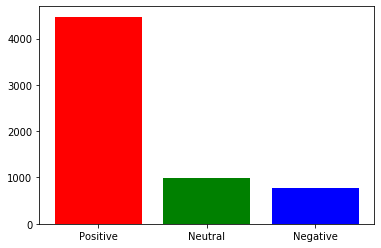

Finding noun adj pairs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271

In [28]:
aspect_polarity,review_polairty=calculate_polarity()

In [29]:
#Ground truth for each review for each aspect
def calculate_score(aspect_polarity,review_polarity,aspects_final):
    score={}

    for i in range(len(reviews_df_new)):
        print(i)
        temp_copy={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}
        aspect_score=aspect_polarity[i]
        b=review_polarity[i]
        for j in range(len(aspects_final)):
            aspect=aspects_final[j]
            if(aspect=='overall'):
                if(b<-0.4):
                    val=1
                elif(b>=-0.4 and b<-0.2):
                    val=2
                elif(b>=-0.2 and b<0.2 ):
                    val=3
                elif(b>=0.2 and b<0.6):
                    val=4
                else:
                    val=5
            else:
            
                to_find=aspect_score[aspect]
            #print(to_find)
                a=0
                count_val=0
                for pair in to_find:
                    a+=pair[1]
                    count_val+=1
                if(count_val!=0):
                    a=a/count_val
                    
                if(a!=0):
                
                    if(a<-0.4):
                        val=1
                    elif(a>=-0.4 and a<-0.2):
                        val=2
                    elif(a>=-0.2 and a<0.2 ):
                        val=3
                    elif(a>=0.2 and a<0.6):
                        val=4
                    else:
                        val=5
                else:
                    val=random.randint(1,5)

            print(val)
            temp_copy[j]=val
        print(temp_copy)
        score[i]=temp_copy
    return score

In [30]:
#Generating the dataset which can be used to train the model
def generating_data(score,review_array):
    #MERGING DATA
    print("merging data")
    data=[]
    for i in range(len(reviews_df_new)):
        print(i)
        scores=score[i]
        review=review_array[i]
    
        for j in range(len(aspects_final)):
            temp=[]
            aspect=aspects_final[j]
            temp.append(j)
            temp.extend(review)
            temp.append(score[i][j])
            data.append(temp)
    #SPLITTING IN TRAIN AND TEST
    print("splitting data")
    train=[]
    test=[]

    train_count=math.ceil(0.8*len(data))
    train=random.sample(range(0, len(data)), train_count) #random samples are generated
    for i in range(len(data)):
        if(i not in train):
            test.append(i)
    print(len(train))
    print(len(test))
    print("generating train and test")
    data=np.array(data)
    n=len(data[0])
    X_train=data[train,0:n-1]
    y_train=data[train,n-1]
    X_test=data[test,0:n-1]
    y_test=data[test,n-1]
    return X_train,y_train,X_test,y_test,test
    

In [34]:
#Performing feature selection on the dataset
def feature_selection(X_train,y_train,X_test):
    X=X_train
    y=y_train
    print("selectiong features")
# define feature selection
    fs = SelectKBest(score_func=f_classif, k=500)

# apply feature selection
    X_selected = fs.fit_transform(X, y)
    columns_new = fs.get_support(indices=True)
    cols=list(columns_new)
    if 0 not in cols:
        cols.append(0)
    print("modifying dataset")
    X_train1=np.array(X_train)
    X_train2=X_train1[:,cols]
    X_test1=np.array(X_test)
    X_test2=X_test1[:,cols]
    return X_train2,X_test2

In [35]:
#Calling all the functions to generate the training and testing data for the ML model
def data_processing():
    print("calculating score")
    score=calculate_score(aspect_polarity,review_polairty,aspects_final)
    print("data geneartion")
    X_train,y_train,X_test,y_test,test=generating_data(score,reviews)
    X_train2,X_test2=feature_selection(X_train,y_train,X_test)
    return X_train2,y_train,X_test2,y_test,test


In [36]:
X_train,y_train,X_test,y_test,test=data_processing()

calculating score
0
3
1
3
3
1
1
3
5
4
{0: 3, 1: 1, 2: 3, 3: 3, 4: 1, 5: 1, 6: 3, 7: 5, 8: 4}
1
4
4
1
4
3
3
3
2
3
{0: 4, 1: 4, 2: 1, 3: 4, 4: 3, 5: 3, 6: 3, 7: 2, 8: 3}
2
3
2
1
3
1
2
3
1
4
{0: 3, 1: 2, 2: 1, 3: 3, 4: 1, 5: 2, 6: 3, 7: 1, 8: 4}
3
3
3
2
1
3
4
1
4
3
{0: 3, 1: 3, 2: 2, 3: 1, 4: 3, 5: 4, 6: 1, 7: 4, 8: 3}
4
4
4
4
3
5
1
5
5
5
{0: 4, 1: 4, 2: 4, 3: 3, 4: 5, 5: 1, 6: 5, 7: 5, 8: 5}
5
3
3
2
1
3
5
5
5
3
{0: 3, 1: 3, 2: 2, 3: 1, 4: 3, 5: 5, 6: 5, 7: 5, 8: 3}
6
4
3
4
4
3
5
2
5
4
{0: 4, 1: 3, 2: 4, 3: 4, 4: 3, 5: 5, 6: 2, 7: 5, 8: 4}
7
4
3
3
3
4
2
3
4
5
{0: 4, 1: 3, 2: 3, 3: 3, 4: 4, 5: 2, 6: 3, 7: 4, 8: 5}
8
3
4
2
3
5
1
5
4
4
{0: 3, 1: 4, 2: 2, 3: 3, 4: 5, 5: 1, 6: 5, 7: 4, 8: 4}
9
4
4
5
2
3
4
5
3
3
{0: 4, 1: 4, 2: 5, 3: 2, 4: 3, 5: 4, 6: 5, 7: 3, 8: 3}
10
4
2
5
3
2
3
4
5
5
{0: 4, 1: 2, 2: 5, 3: 3, 4: 2, 5: 3, 6: 4, 7: 5, 8: 5}
11
4
4
1
1
5
3
5
4
5
{0: 4, 1: 4, 2: 1, 3: 1, 4: 5, 5: 3, 6: 5, 7: 4, 8: 5}
12
4
4
4
1
4
1
1
4
4
{0: 4, 1: 4, 2: 4, 3: 1, 4: 4, 5: 1, 6: 1, 7: 4, 8: 4}
13
3

In [ ]:
#Following cells contain various models that have been used by us
#LINEAR REGRESSION
#LOGISTIC REGRESSION
#GRADIENT BOOSTING REGRESSOR

In [37]:
#linear regression
lmodel=LinearRegression()
print("Fitting in the model")
lmodel.fit(X_train,y_train)
print("Predicting")
y_pred=lmodel.predict(X_test)


Fitting in the model
Predicting


In [40]:
print("Mean absolute error for Linear Regression",metrics.mean_absolute_error(y_pred,y_test))
print("Mean square error for Linear Regression",metrics.mean_squared_error(y_pred,y_test))



Mean absolute error for Linear Regression 1.1751485161130026
Mean square error for Linear Regression 1.9214322741448808


In [39]:
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
print("Fitting in the model")
lr.fit(X_train,y_train)
print("Predicting")
y_pred1 = lr.predict(X_test)


Fitting in the model
Predicting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [42]:
print("Mean absolute error for Logistic Regression",metrics.mean_absolute_error(y_pred1,y_test))
print("Mean square error for Logistic Regression",metrics.mean_squared_error(y_pred1,y_test))

Mean absolute error for Logistic Regression 1.3601992705275332
Mean square error for Logistic Regression 3.0180588915576907


In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, random_state=1, verbose=1)
print("Fitting in the model")
gbr.fit(X_train, y_train)
print("Predicting")
y_pred2 = gbr.predict(X_test)



Fitting in the model
      Iter       Train Loss   Remaining Time 
         1           1.8752            1.23m
         2           1.8662            1.22m
         3           1.8586            1.21m
         4           1.8524            1.20m
         5           1.8473            1.20m
         6           1.8430            1.19m
         7           1.8395            1.18m
         8           1.8364            1.18m
         9           1.8338            1.17m
        10           1.8315            1.16m
        20           1.8179            1.07m
        30           1.8127           55.95s
        40           1.8095           49.02s
        50           1.8069           43.54s
        60           1.8041           39.44s
        70           1.8014           35.75s
        80           1.7989           32.42s
        90           1.7965           29.32s
       100           1.7944           26.32s
       200           1.7765            0.00s
Predicting


In [44]:
print("Mean absolute error for Gradient Boosting Regressor",metrics.mean_absolute_error(y_pred2,y_test))
print("Mean square error for Gradient Boosting Regressor",metrics.mean_squared_error(y_pred2,y_test))



Mean absolute error for Gradient Boosting Regressor 1.1363485443243067
Mean square error for Gradient Boosting Regressor 1.8312280893921933


In [ ]:
#Following cells are used to generate the output from the model
#NDGC is used as an evaluation criteria

In [117]:
def idgc(sorted_ground):
    dcg=0
    for i in range(len(sorted_ground)):
        #print(i)
        pair=sorted_ground[i]
        #print(pair)
        den=math.log(i+1,2)
        rel=pair[1]
        x=((2**rel)-1)
        if(den!=0):
            dcg+=(x/den)
    return dcg

In [119]:
def ndgc(sorted_ground,sorted_pred,product_test_values):
    idgc_val=idgc(sorted_ground)
    dgc=0
    for i in range(len(sorted_pred)):
        pair=sorted_pred[i]
        pid=pair[0]
        rel=product_test_values[pid]
        x=(2**rel)-1
        den=math.log(i+1,2)
        if(den!=0):
            dgc+=(x/den)
    ans=dgc/idgc_val
    return ans
        

In [ ]:
from nltk.corpus import wordnet 
def query_processing(query):
    index=8
    synonyms=[]
    for syn in wordnet.synsets(query): 
        for l in syn.lemmas(): 
            synonyms.append(l.name())
    synonyms=set(synonyms)
    if query in aspects_final:
        index= aspects_final.index(query)
    else:
        for i in synonyms:
            if i in aspects_final:
                index= aspects_final.index(i)
    return index




In [207]:
def run_model(y_pred,y_test,test,products,X_test):
    query=input("Enter the aspect \n")
    ans=query_processing(query)
    print("Model is Gradient Boosting Regressor")
    print("Aspect is:",aspects_final[ans])
   #print("Qid for query is : ",ans)
    #print("predicting")
    #k=int(input("Enter no of products you want to retrieve"))
    y_query_pred=[]
    y_ground=[]
    index_list=[]
    for i in range(len(test)):
        
        if(X_test[i,0]==ans):
            #print(test[i])
            index_list.append(test[i])
            y_query_pred.append(y_pred[i])
            y_ground.append(y_test[i])
    
    product_test_values={}
    product_pred_values={}
    query_pred=[]
    query_ground=[]
    retrieved_items=[]
    count_test={}
    for i in products:
        count_test[i]=0
    for i in index_list:
    
        index=i//9
    
        pid=reviews_df_new.iloc[index,0]
        count_test[pid]+=1
#print(count_test)
    for i in products:
        product_test_values[i]=0
        product_pred_values[i]=0
    for j in range(len(index_list)):
    
        index=index_list[j]//9
    
        product_id=reviews_df_new.iloc[index,0]
        product_test_values[product_id]+=y_ground[j]
        product_pred_values[product_id]+=y_query_pred[j]
    #print(product_test_values)
    #print(product_pred_values)

    for p in products:
        if(count_test[p]!=0):
            product_test_values[p]/=count_test[p]
            product_pred_values[p]/=count_test[p]
    
    sorted_pred=sort_dict(product_pred_values)
    sorted_ground=sort_dict(product_test_values)
    #print(sorted_ground)
    #print(sorted_pred)

    for i in sorted_pred:
        query_pred.append(i[1])
        retrieved_items.append(i[0])
    for i in sorted_ground:
        query_ground.append(i[1])
    print("NDGC Score is:",ndgc(sorted_ground[0:40],sorted_pred[0:40],product_test_values))
    print("\n")
    item_name_mapping={}
    for i in products:
        item_name_mapping[i]=items_df[items_df['asin']==i]['title']
    print("List of items are ranked for ",query)
    print("\n")
    for i in range(5):
        print(item_name_mapping[sorted_pred[i][0]])


In [208]:
run_model(y_pred2,y_test,test,products,X_test)

Enter the aspect 
screen
Model is Gradient Boosting Regressor
Aspect is: screen
NDGC Score is: 0.9052446010771693


List of items are ranked for  screen


52    Samsung Galaxy S4 M919 16GB T-Mobile 4G LTE Sm...
Name: title, dtype: object
78    Motorola Moto X - 2nd Generation, Black Resin ...
Name: title, dtype: object
240    Samsung Galaxy S8 Plus (S8+) (SM-G955FD) 4GB R...
Name: title, dtype: object
222    Samsung Galaxy S8 SM-G950F Unlocked 64GB - Int...
Name: title, dtype: object
493    Apple iPhone XS, 256GB, Gold - Fully Unlocked ...
Name: title, dtype: object


In [219]:
aspects=['battery','volume','screen','cost']
ndgc_aspectwise_linear=[0.8907528938271746,0.9288670118973724,0.945602945035116 ,0.9559841054129231]
ndgc_aspectwise_logistic=[0.9307339833042494,0.9491347985266905,0.9760712615565023, 0.972174755413349]
ndgc_aspectwise_gbr=[0.9072936299939266,0.9356740867375528,0.9594440693849062,0.9250170872191908]

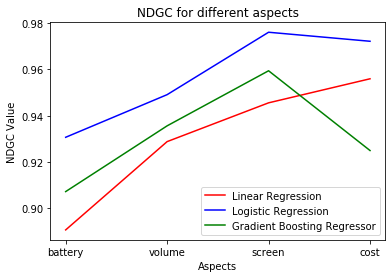

In [220]:
plt.plot(aspects,ndgc_aspectwise_linear,color='red',label='Linear Regression')
plt.plot(aspects,ndgc_aspectwise_logistic,color='blue',label='Logistic Regression')
plt.plot(aspects,ndgc_aspectwise_gbr,color='green',label='Gradient Boosting Regressor')
plt.title("NDGC for different aspects")
plt.legend()
plt.xlabel("Aspects")
plt.ylabel("NDGC Value")
plt.show()


In [221]:
x=[5,10,15,20,25,30,35,40]
ndgc_n_linear=[0.7680899138156646,0.8012091700956717,0.8050002855554593,0.8482339421098991,0.849447052054526,0.8619700515616737,0.8744155439913693,0.8939547391630343]
ndgc_n_log=[0.9601563525405732,0.888344761057985,0.9482418558390452,0.9010360810335972,0.8951441262183087,0.9056900424510985,0.9288588009152131,0.9358389760277]
ndgc_n_gbr=[0.823596397372987,0.8623105349516035,0.8673307710652366,0.8705263223837681,0.887273467040922,0.8840706108487579,0.8918349363109261,0.9052446010771693]

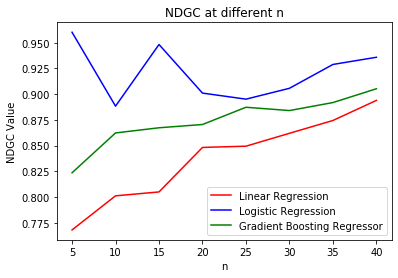

In [222]:
plt.plot(x,ndgc_n_linear,color='red',label='Linear Regression')
plt.plot(x,ndgc_n_log,color='blue',label='Logistic Regression')
plt.plot(x,ndgc_n_gbr,color='green',label='Gradient Boosting Regressor')
plt.title("NDGC at different n")
plt.legend()
plt.xlabel("n")
plt.ylabel("NDGC Value")
plt.show()

